In [2]:
import comet_ml
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

comet_api = comet_ml.api.API()

In [3]:
class ExperminetInfo:
    def __init__(self, comet_api, exp_id):
        self.exp = comet_api.get(exp_id)
        self.__metrics = None

    @property
    def metrics(self):
        if self.__metrics is None:
            self.__metrics = self.exp.get_metrics()
        return self.__metrics

    @property
    def metric_names(self):
        return np.unique([m['metricName'] for m in self.metrics])

    def get_metrics_df(self, metric_names=None):
        if metric_names is None:
            metric_names = self.metric_names

        values_dict = defaultdict(lambda: {'d': [], 'i': []})
        for metric_name in metric_names:
            metrics = self.exp.get_metrics(metric_name)
            for m in metrics:
                if m['step'] is not None:
                    v = values_dict[m['metricName']]
                    v['d'].append(float(m['metricValue']))
                    v['i'].append(m['step'])
        return pd.DataFrame({k: pd.Series(v['d'], v['i']) for k, v in values_dict.items()})

In [4]:
expinf = ExperminetInfo(comet_api, 'federated-learning/server-side-opt-long/6ff84da994984903a518738f674b6046')

In [5]:
train_loss_metric_names = [m for m in expinf.metric_names if m.endswith('_train_loss')]

In [6]:
df = expinf.get_metrics_df(train_loss_metric_names)

Text(0.5, 0.98, 'Yogi learning curves')

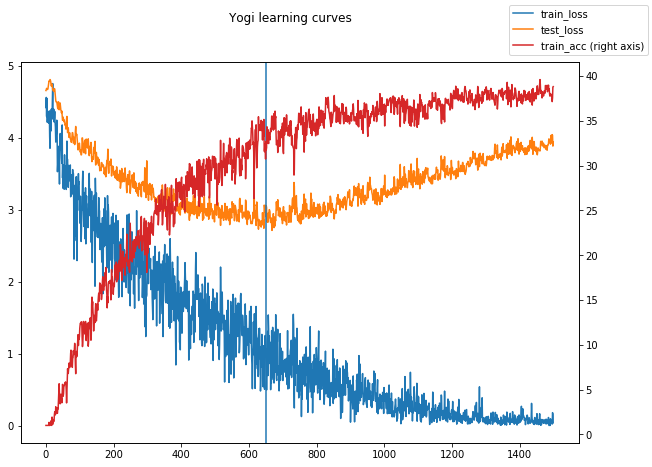

In [36]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(df.min(axis=1), label='train_loss')
ax1.plot(expinf.get_metrics_df(['test_loss']), label='test_loss')
ax2 = ax1.twinx()
ax2.plot(expinf.get_metrics_df(['test_acc']), label='train_acc (right axis)',color = 'tab:red')
ax1.axvline(650)
fig.legend(loc='upper right')
fig.suptitle('Yogi learning curves')